# Data Scientist Technical Test : Car insurance prediction 

## Import useful modules 

In [67]:
#generic modules and settings

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF8')
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn ML modules

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

## Data Processing 

In [68]:
#import data from csv and first visualization

df = pd.read_csv(r'train_auto.csv', sep=None, engine='python')
df

,ï»¿INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,z_F,PhD,Doctor,36,Private,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8156,10297,0,0.0,0,35.0,0,11.0,"$43,112",No,$0,z_No,M,z_High School,z_Blue Collar,51,Commercial,"$27,330",10,Panel Truck,yes,$0,0,No,0,8.0,z_Highly Rural/ Rural
8157,10298,0,0.0,1,45.0,2,9.0,"$164,669",No,"$386,273",Yes,M,PhD,Manager,21,Private,"$13,270",15,Minivan,no,$0,0,No,2,17.0,Highly Urban/ Urban
8158,10299,0,0.0,0,46.0,0,9.0,"$107,204",No,"$332,591",Yes,M,Masters,NaN,36,Commercial,"$24,490",6,Panel Truck,no,$0,0,No,0,1.0,Highly Urban/ Urban
8159,10301,0,0.0,0,50.0,0,7.0,"$43,445",No,"$149,248",Yes,z_F,Bachelors,Home Maker,36,Private,"$22,550",6,Minivan,no,$0,0,No,0,11.0,Highly Urban/ Urban


In [69]:
#check volume of target value ("TARGET_FLAG")

df['TARGET_FLAG'].value_counts()

0    6008
1    2153
Name: TARGET_FLAG, dtype: int64

### Processing the train data

The dataframe at hand contains non-numerical values, so we have to process these columns in several ways : 

    - transform currencies into numbers 
    
    - change non-numerical binary variables into numerical ones (0 or 1)
    
    - for columns with multiple non-numerical values, we can transform them into a numerical scale if it makes sense, or 
    create binary dummy variables for each value 

In [77]:
y_train = pd.DataFrame.copy(df['TARGET_FLAG'])

index = pd.DataFrame.copy(df['ï»¿INDEX'])
target_amt = pd.DataFrame.copy(df['TARGET_AMT'])
kids_driv = pd.DataFrame.copy(df['KIDSDRIV'])
age = pd.DataFrame.copy(df['AGE'])
home_kids = pd.DataFrame.copy(df['HOMEKIDS'])
YOJ = pd.DataFrame.copy(df['YOJ'])
trav_time = pd.DataFrame.copy(df['TRAVTIME'])
TIF = pd.DataFrame.copy(df['TIF'])
clm_freq = pd.DataFrame.copy(df['CLM_FREQ'])
mvr_pts = pd.DataFrame.copy(df['MVR_PTS'])
car_age = pd.DataFrame.copy(df['CAR_AGE'])

income = pd.DataFrame.copy(df['INCOME'])
home_val = pd.DataFrame.copy(df['HOME_VAL'])
blue_book = pd.DataFrame.copy(df['BLUEBOOK'])
old_claim = pd.DataFrame.copy(df['OLDCLAIM'])


#transform the currency values into numbers

for i in range(len(df['INCOME'])):
    value1 = locale.atof(str(income[i]).strip("$"))
    income[i] = str(value1)
    value2 = locale.atof(str(home_val[i]).strip("$"))
    home_val[i] = str(value2)
    value3 = locale.atof(str(blue_book[i]).strip("$"))
    blue_book[i] = str(value3)
    value4 = locale.atof(str(old_claim[i]).strip("$"))
    old_claim[i] = str(value4)

    
#changing non-numerical binary variables (e.g. Yes/No) into a numerical binary variable (0 or 1)
    
def binary_variable(series, str1, str0):
    series_new = pd.DataFrame.copy(df['TARGET_FLAG'])
    for i in range(len(df['TARGET_FLAG'])):
        if series[i] == str1:
            series_new[i] = 1
        elif series[i] == str0:
            series_new[i] = 0
        else :
            print("non recognized value")
    return(series_new)


parent_1 = binary_variable(df['PARENT1'], "Yes", "No")
m_status = binary_variable(df['MSTATUS'], "Yes", "z_No")
sex = binary_variable(df['SEX'], "M", "z_F")
car_use = binary_variable(df['CAR_USE'], "Commercial", "Private")
red_car = binary_variable(df['RED_CAR'], "yes", "no")
revoked = binary_variable(df['REVOKED'], "Yes", "No")
urbanicity = binary_variable(df['URBANICITY'], "Highly Urban/ Urban", "z_Highly Rural/ Rural")


#transforming education level into a 0-4 scale 

education = pd.DataFrame.copy(df['EDUCATION'])
for i in range(len(df['EDUCATION'])):
    if education[i] == '<High School':
        education[i] = 0
    if education[i] == 'z_High School':
        education[i] = 1
    if education[i] == 'Bachelors':
        education[i] = 2
    if education[i] == 'Masters':
        education[i] = 3
    if education[i] == 'PhD':
        education[i] = 4
                
#for variables with multiple non-numerical and non-hierarchical values : we create several binary dummy variables       
        
def create_dummy_variables(series):
    unique = series.unique()
    df_dummy = pd.DataFrame(0, index=np.arange(len(series)), columns=unique)
    for i in range(len(unique)):
        name = unique[i]
        for j in range(len(series)):
            if series[j] == name:
                df_dummy[name][j] = 1
            else:
                df_dummy[name][j] = 0
    
    return(df_dummy)

df_dummy_car_type = create_dummy_variables(df['CAR_TYPE'])
df_dummy_job = create_dummy_variables(df['JOB'])


#finally, we re-assemble all the variables into a fully-numerical dataframe

concat_list_1 = {"y_train": y_train,
                 "kids_driv": kids_driv,
                 "age": age,
                 "home_kids": home_kids,
                 "YOJ": YOJ,
                 "income": income,
                 "parent_1": parent_1,
                 "home_val": home_val,
                 "m_status": m_status,
                 "sex": sex,
                 "education": education,
                 "trav_time": trav_time,
                 "car_use": car_use,
                 "blue_book": blue_book,
                 "TIF": TIF,
                 "red_car": red_car,
                 "old_claim": old_claim,
                 "clm_freq": clm_freq,
                 "revoked": revoked,
                 "mvr_pts": mvr_pts,
                 "car_age": car_age,
                 "urbanicity": urbanicity}
            

df_concat_1 = pd.concat(concat_list_1, axis = 1)

df_concat_train = pd.concat([df_concat_1, df_dummy_car_type, df_dummy_job], axis=1)

df_concat_train = df_concat_train.drop(df_concat_train.columns[34],axis = 1)

In [78]:
#visualize the processed train dataframe

df_concat_train

,y_train,kids_driv,age,home_kids,YOJ,income,parent_1,home_val,m_status,sex,education,trav_time,car_use,blue_book,TIF,red_car,old_claim,clm_freq,revoked,mvr_pts,car_age,urbanicity,Minivan,z_SUV,Sports Car,Van,Panel Truck,Pickup,Professional,z_Blue Collar,Clerical,Doctor,Lawyer,Manager,Home Maker,Student
0,0,0,60.0,0,11.0,67349.0,0,0.0,0,1,4,14,0,14230.0,11,1,4461.0,2,0,3,18.0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,43.0,0,11.0,91449.0,0,257252.0,0,1,1,22,1,14940.0,1,1,0.0,0,0,0,1.0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,35.0,1,10.0,16039.0,0,124191.0,1,0,1,5,0,4010.0,4,0,38690.0,2,0,3,10.0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,51.0,0,14.0,nan,0,306251.0,1,1,0,32,0,15440.0,7,1,0.0,0,0,0,6.0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,50.0,0,NaN,114986.0,0,243925.0,1,0,4,36,0,18000.0,1,0,19217.0,2,1,3,17.0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8156,0,0,35.0,0,11.0,43112.0,0,0.0,0,1,1,51,1,27330.0,10,1,0.0,0,0,0,8.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
8157,0,1,45.0,2,9.0,164669.0,0,386273.0,1,1,4,21,0,13270.0,15,0,0.0,0,0,2,17.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0
8158,0,0,46.0,0,9.0,107204.0,0,332591.0,1,1,3,36,1,24490.0,6,0,0.0,0,0,0,1.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
8159,0,0,50.0,0,7.0,43445.0,0,149248.0,1,0,2,36,0,22550.0,6,0,0.0,0,0,0,11.0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0


We still have "NaN" values that must be removed for prediction. We can either remove columns with many "NaN" values, or delete all rows that contain at least one "NaN".

In [79]:
#count the number of "NaN" values per column

p = df_concat_train.isnull().sum(axis=0)
cpt=0
for i in range(len(df_concat_train.columns)):
    if p[i]!= 0:
        print(df_concat_train.columns[i], p[i])
        cpt = cpt + 1
print("\n")   
print("number of columns with null values : ", cpt)

age 6
YOJ 454
car_age 510


number of columns with null values :  3


We could choose to remove "YOJ" and "car_age" columns as they have most "NaN" values, but they intuitively seem like important prediction variables for insurance. We choose to drop all rows with a "NaN" value. 

In [80]:
#drop all rows with a "NaN" value

df_concat_train = df_concat_train[~df_concat_train.isin([np.nan]).any(1)]
df_concat_train = df_concat_train.reset_index(drop=True)

In [81]:
#check if this worked

p = df_concat_train.isnull().sum(axis=0)
cpt=0
for i in range(len(df_concat_train.columns)):
    if p[i]!= 0:
        cpt = cpt + 1
print("number of rows with null values : ", cpt)

number of rows with null values :  0


In [82]:
#we also have "nan" values which weren't treated by the previous processing, so we delete the rows containing them

liste_train = []
for i in range(len(df_concat_train)):
    for j in df_concat_train.columns:
        if (df_concat_train[j][len(df_concat_train) - 1 - i] == 'nan'):
            if (len(df_concat_train) - 1 - i) not in liste_train:
                liste_train.append(len(df_concat_train) - 1 - i)

In [83]:
#we visualize our completely processed train data

df_concat_train = df_concat_train.drop(df.index[liste_train])
df_concat_train = df_concat_train.reset_index(drop=True)
df_concat_train

,y_train,kids_driv,age,home_kids,YOJ,income,parent_1,home_val,m_status,sex,education,trav_time,car_use,blue_book,TIF,red_car,old_claim,clm_freq,revoked,mvr_pts,car_age,urbanicity,Minivan,z_SUV,Sports Car,Van,Panel Truck,Pickup,Professional,z_Blue Collar,Clerical,Doctor,Lawyer,Manager,Home Maker,Student
0,0,0,60.0,0,11.0,67349.0,0,0.0,0,1,4,14,0,14230.0,11,1,4461.0,2,0,3,18.0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,43.0,0,11.0,91449.0,0,257252.0,0,1,1,22,1,14940.0,1,1,0.0,0,0,0,1.0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,35.0,1,10.0,16039.0,0,124191.0,1,0,1,5,0,4010.0,4,0,38690.0,2,0,3,10.0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
3,1,0,34.0,1,12.0,125301.0,1,0.0,0,0,2,46,1,17430.0,1,0,0.0,0,0,0,7.0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
4,1,0,34.0,0,10.0,62978.0,0,0.0,0,0,2,34,0,11200.0,1,0,0.0,0,0,0,1.0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6443,0,0,35.0,0,11.0,43112.0,0,0.0,0,1,1,51,1,27330.0,10,1,0.0,0,0,0,8.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
6444,0,1,45.0,2,9.0,164669.0,0,386273.0,1,1,4,21,0,13270.0,15,0,0.0,0,0,2,17.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0
6445,0,0,46.0,0,9.0,107204.0,0,332591.0,1,1,3,36,1,24490.0,6,0,0.0,0,0,0,1.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6446,0,0,50.0,0,7.0,43445.0,0,149248.0,1,0,2,36,0,22550.0,6,0,0.0,0,0,0,11.0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0


### Processing the test data

We apply the same processing to the test data

In [84]:
df_test = pd.read_csv(r'test_auto.csv', sep=None, engine='python')

In [150]:
y_test = pd.DataFrame.copy(df_test['TARGET_FLAG'])

index_test = pd.DataFrame.copy(df_test['ï»¿INDEX'])
target_amt_test = pd.DataFrame.copy(df_test['TARGET_AMT'])
kids_driv_test = pd.DataFrame.copy(df_test['KIDSDRIV'])
age_test = pd.DataFrame.copy(df_test['AGE'])
home_kids_test = pd.DataFrame.copy(df_test['HOMEKIDS'])
YOJ_test = pd.DataFrame.copy(df_test['YOJ'])
trav_time_test = pd.DataFrame.copy(df_test['TRAVTIME'])
TIF_test = pd.DataFrame.copy(df_test['TIF'])
clm_freq_test = pd.DataFrame.copy(df_test['CLM_FREQ'])
mvr_pts_test = pd.DataFrame.copy(df_test['MVR_PTS'])
car_age_test = pd.DataFrame.copy(df_test['CAR_AGE'])

income_test = pd.DataFrame.copy(df_test['INCOME'])
home_val_test = pd.DataFrame.copy(df_test['HOME_VAL'])
blue_book_test = pd.DataFrame.copy(df_test['BLUEBOOK'])
old_claim_test = pd.DataFrame.copy(df_test['OLDCLAIM'])

for i in range(len(df_test['INCOME'])):
    value1 = locale.atof(str(income_test[i]).strip("$"))
    income_test[i] = str(value1)
    value2 = locale.atof(str(home_val_test[i]).strip("$"))
    home_val_test[i] = str(value2)
    value3 = locale.atof(str(blue_book_test[i]).strip("$"))
    blue_book_test[i] = str(value3)
    value4 = locale.atof(str(old_claim_test[i]).strip("$"))
    old_claim_test[i] = str(value4)

    
def binary_variable_test(series, str1, str0):
    series_new = pd.DataFrame.copy(df_test['TARGET_FLAG'])
    for i in range(len(df_test['TARGET_FLAG'])):
        if series[i] == str1:
            series_new[i] = 1
        elif series[i] == str0:
            series_new[i] = 0
        else :
            print("non recognized value")
    return(series_new)


parent_1_test = binary_variable_test(df_test['PARENT1'], "Yes", "No")
m_status_test = binary_variable_test(df_test['MSTATUS'], "Yes", "z_No")
sex_test = binary_variable_test(df_test['SEX'], "M", "z_F")
car_use_test = binary_variable_test(df_test['CAR_USE'], "Commercial", "Private")
red_car_test = binary_variable_test(df_test['RED_CAR'], "yes", "no")
revoked_test = binary_variable_test(df_test['REVOKED'], "Yes", "No")
urbanicity_test = binary_variable_test(df_test['URBANICITY'], "Highly Urban/ Urban", "z_Highly Rural/ Rural")


education_test = pd.DataFrame.copy(df_test['EDUCATION'])
for i in range(len(df_test['EDUCATION'])):
    if education_test[i] == '<High School':
        education_test[i] = 0
    if education_test[i] == 'z_High School':
        education_test[i] = 1
    if education_test[i] == 'Bachelors':
        education_test[i] = 2
    if education_test[i] == 'Masters':
        education_test[i] = 3
    if education_test[i] == 'PhD':
        education_test[i] = 4


df_dummy_car_type_test = create_dummy_variables(df_test['CAR_TYPE'])
df_dummy_job_test = create_dummy_variables(df_test['JOB'])

concat_list_1_test = {"index": index_test,
                 "kids_driv": kids_driv_test,
                 "age": age_test,
                 "home_kids": home_kids_test,
                 "YOJ": YOJ_test,
                 "income": income_test,
                 "parent_1": parent_1_test,
                 "home_val": home_val_test,
                 "m_status": m_status_test,
                 "sex": sex_test,
                 "education": education_test,
                 "trav_time": trav_time_test,
                 "car_use": car_use_test,
                 "blue_book": blue_book_test,
                 "TIF": TIF_test,
                 "red_car": red_car_test,
                 "old_claim": old_claim_test,
                 "clm_freq": clm_freq_test,
                 "revoked": revoked_test,
                 "mvr_pts": mvr_pts_test,
                 "car_age": car_age_test,
                 "urbanicity": urbanicity_test}
            

df_concat_1_test = pd.concat(concat_list_1_test, axis = 1)

df_concat_test = pd.concat([df_concat_1_test, df_dummy_car_type_test, df_dummy_job_test], axis=1)

df_concat_test = df_concat_test.drop(df_concat_test.columns[33],axis = 1)

In [151]:
p = df_concat_test.isnull().sum(axis=0)
cpt=0
for i in range(len(df_concat_test.columns)):
    if p[i]!= 0:
        print(df_concat_test.columns[i], p[i])
        cpt = cpt + 1
print("\n")   
print("number of rows with null values : ", cpt)

age 1
YOJ 94
car_age 129


number of rows with null values :  3


In [152]:
df_concat_test = df_concat_test[~df_concat_test.isin([np.nan]).any(1)]
df_concat_test = df_concat_test.reset_index(drop=True)

In [153]:
p = df_concat_test.isnull().sum(axis=0)
cpt=0
for i in range(len(df_concat_test.columns)):
    if p[i]!= 0:
        cpt = cpt + 1
print("number of rows with null values : ", cpt)

number of rows with null values :  0


In [154]:
liste_test = []
for i in range(len(df_concat_test)):
    for j in df_concat_test.columns:
        if (df_concat_test[j][len(df_concat_test) - 1 - i] == 'nan'):
            if (len(df_concat_test) - 1 - i) not in liste_test:
                liste_test.append(len(df_concat_test) - 1 - i)

In [155]:
df_concat_test = df_concat_test.drop(df.index[liste_test])
df_concat_test = df_concat_test.reset_index(drop=True)
index_test_processed = df_concat_test['index']
df_concat_test = df_concat_test.drop('index',axis = 1)
df_concat_test

,kids_driv,age,home_kids,YOJ,income,parent_1,home_val,m_status,sex,education,trav_time,car_use,blue_book,TIF,red_car,old_claim,clm_freq,revoked,mvr_pts,car_age,urbanicity,Van,Minivan,z_SUV,Pickup,Panel Truck,Sports Car,Manager,z_Blue Collar,Clerical,Professional,Doctor,NaN,Student,Home Maker
0,0,48.0,0,11.0,52881.0,0.0,0.0,0.0,1.0,2,26,0.0,21970.0,1,1.0,0.0,0,0.0,2,10.0,1.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1,40.0,1,11.0,50815.0,1.0,0.0,0.0,1.0,1,21,0.0,18930.0,6,0.0,3295.0,1,0.0,2,1.0,1.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2,0,44.0,2,12.0,43486.0,1.0,0.0,0.0,0.0,1,30,1.0,5900.0,10,0.0,0.0,0,0.0,0,10.0,0.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
3,0,59.0,0,12.0,87460.0,0.0,0.0,0.0,1.0,1,45,0.0,15420.0,1,1.0,44857.0,2,0.0,4,1.0,1.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
4,0,60.0,0,12.0,37940.0,0.0,182739.0,1.0,0.0,1,16,1.0,11290.0,1,0.0,0.0,0,0.0,0,1.0,1.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710,0,46.0,0,0.0,0.0,0.0,0.0,1.0,0.0,1,32,1.0,1500.0,6,0.0,20519.0,1,1.0,3,8.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1711,0,46.0,0,12.0,43501.0,0.0,134977.0,1.0,1.0,1,60,0.0,16080.0,3,0.0,0.0,0,0.0,2,1.0,0.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1712,0,55.0,0,10.0,141083.0,0.0,393624.0,1.0,0.0,3,42,0.0,21110.0,10,0.0,0.0,0,0.0,0,22.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1713,0,51.0,0,10.0,128523.0,0.0,0.0,0.0,1.0,3,18,1.0,32960.0,6,0.0,3995.0,3,0.0,1,15.0,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


## Standardizing the train and test data

As we are handling data with many different units, we standardize the data to avoid giving too much weight to parameters with higher values and variance

In [94]:
#separate the column we wish to predict from the train data

y_train = df_concat_train['y_train']
df_concat_train = df_concat_train.drop(columns = 'y_train')

In [95]:
#standardize the train and test data

scaler = StandardScaler()
df_standard_train = pd.DataFrame(scaler.fit_transform(df_concat_train), columns = df_concat_train.columns)
df_standard_test = pd.DataFrame(scaler.fit_transform(df_concat_test), columns = df_concat_test.columns)

In [96]:
#visualize the standardized data

df_standard_train

,kids_driv,age,home_kids,YOJ,income,parent_1,home_val,m_status,sex,education,trav_time,car_use,blue_book,TIF,red_car,old_claim,clm_freq,revoked,mvr_pts,car_age,urbanicity,Minivan,z_SUV,Sports Car,Van,Panel Truck,Pickup,Professional,z_Blue Collar,Clerical,Doctor,Lawyer,Manager,Home Maker,Student
0,-0.332431,1.756852,-0.646500,0.113419,0.112374,-0.391776,-1.198950,-1.210302,1.072070,1.867696,-1.240957,-0.771013,-0.181504,1.355444,1.557608,0.046862,1.036935,-0.373665,0.599710,1.698142,0.505906,1.660595,-0.621585,-0.354262,-0.313496,-0.298646,-0.456256,2.535463,-0.544851,-0.436265,-0.178914,-0.340525,-0.370694,-0.284875,-0.301409
1,-0.332431,-0.200551,-0.646500,0.113419,0.620528,-0.391776,0.785326,-1.210302,1.072070,-0.671394,-0.736031,1.296995,-0.097316,-1.054899,1.557608,-0.457401,-0.684748,-0.373665,-0.790105,-1.276727,0.505906,1.660595,-0.621585,-0.354262,-0.313496,-0.298646,-0.456256,-0.394405,1.835365,-0.436265,-0.178914,-0.340525,-0.370694,-0.284875,-0.301409
2,-0.332431,-1.121682,0.244805,-0.132405,-0.969509,-0.391776,-0.241021,0.826240,-0.932775,-0.671394,-1.808998,-0.771013,-1.393323,-0.331796,-0.642010,3.916049,1.036935,-0.373665,0.599710,0.298203,0.505906,-0.602194,1.608789,-0.354262,-0.313496,-0.298646,-0.456256,-0.394405,-0.544851,2.292187,-0.178914,-0.340525,-0.370694,-0.284875,-0.301409
3,-0.332431,-1.236823,0.244805,0.359244,1.334305,2.552479,-1.198950,-1.210302,-0.932775,0.174969,0.778747,1.296995,0.197931,-1.054899,-0.642010,-0.457401,-0.684748,-0.373665,-0.790105,-0.226774,0.505906,-0.602194,-0.621585,2.822767,-0.313496,-0.298646,-0.456256,-0.394405,1.835365,-0.436265,-0.178914,-0.340525,-0.370694,-0.284875,-0.301409
4,-0.332431,-1.236823,-0.646500,-0.132405,0.020211,-0.391776,-1.198950,-1.210302,-0.932775,0.174969,0.021358,-0.771013,-0.540781,-1.054899,-0.642010,-0.457401,-0.684748,-0.373665,-0.790105,-1.276727,0.505906,-0.602194,1.608789,-0.354262,-0.313496,-0.298646,-0.456256,-0.394405,-0.544851,2.292187,-0.178914,-0.340525,-0.370694,-0.284875,-0.301409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6443,-0.332431,-1.121682,-0.646500,0.113419,-0.398668,-0.391776,-1.198950,-1.210302,1.072070,-0.671394,1.094326,1.296995,1.371808,1.114410,1.557608,-0.457401,-0.684748,-0.373665,-0.790105,-0.051781,-1.976652,-0.602194,-0.621585,-0.354262,-0.313496,3.348451,-0.456256,-0.394405,1.835365,-0.436265,-0.178914,-0.340525,-0.370694,-0.284875,-0.301409
6444,1.632294,0.029732,1.136109,-0.378230,2.164388,-0.391776,1.780511,0.826240,1.072070,1.867696,-0.799146,-0.771013,-0.295334,2.319582,-0.642010,-0.457401,-0.684748,-0.373665,0.136438,1.523150,0.505906,1.660595,-0.621585,-0.354262,-0.313496,-0.298646,-0.456256,-0.394405,-0.544851,-0.436265,-0.178914,-0.340525,2.697643,-0.284875,-0.301409
6445,-0.332431,0.144873,-0.646500,-0.378230,0.952725,-0.391776,1.366443,0.826240,1.072070,1.021333,0.147590,1.296995,1.035059,0.150273,-0.642010,-0.457401,-0.684748,-0.373665,-0.790105,-1.276727,0.505906,-0.602194,-0.621585,-0.354262,-0.313496,3.348451,-0.456256,-0.394405,-0.544851,-0.436265,-0.178914,-0.340525,-0.370694,-0.284875,-0.301409
6446,-0.332431,0.605439,-0.646500,-0.869879,-0.391647,-0.391776,-0.047747,0.826240,-0.932775,0.174969,0.147590,-0.771013,0.805027,0.150273,-0.642010,-0.457401,-0.684748,-0.373665,-0.790105,0.473196,0.505906,1.660595,-0.621585,-0.354262,-0.313496,-0.298646,-0.456256,-0.394405,-0.544851,-0.436265,-0.178914,-0.340525,-0.370694,3.510315,-0.301409


## Split the train data into train and test subsets to check performance

In [97]:
X_train_0, X_test_0, Y_train_0, Y_test_0 = train_test_split(df_standard_train, y_train, test_size = 0.25)

# this splits the data into three quarters for training the models and one quarter for testing them 

X_test = X_test_0.sort_index(ignore_index = True)
X_train = X_train_0.sort_index(ignore_index = True)
Y_test = Y_test_0.sort_index(ignore_index = True)
Y_train = Y_train_0.sort_index(ignore_index = True)

## Logistic Regression 

Binary logistic regression is a statistical technique used to predict the relationship between the dependent variable (Y) and the independent variable (X), where the dependent variable is binary in nature (here TARGET_FLAG = 0 or 1)

In [98]:
#we fit the model on the train subset and use it to predict the target_flag for the test subset.

logisticRegr = LogisticRegression()
log = logisticRegr.fit(X_train, Y_train)
y_predict_log = logisticRegr.predict(X_test)

### Metrics discussion 

In [99]:
#create confusion matrix

y_actual = pd.Series(Y_test, name='Actual')
y_predicted = pd.Series(y_predict_log, name='Predicted')

print(pd.crosstab(y_actual, y_predicted))

Predicted     0    1
Actual              
0          1084   87
1           253  188


The confusion matrix shows that :
- out of the 1171 rows in the test subset with TARGET_FLAG = 0, we predicted 1084 of them correctly (93%) 
- out of the 441 rows in the test subset with TARGET_FLAG = 1, we predicted 188 of them correctly (43%)

In [100]:
print("Classification Report is: \n",classification_report(Y_test, y_predict_log)) 

Classification Report is: 
               precision    recall  f1-score   support

           0       0.81      0.93      0.86      1171
           1       0.68      0.43      0.53       441

    accuracy                           0.79      1612
   macro avg       0.75      0.68      0.69      1612
weighted avg       0.78      0.79      0.77      1612



The classification report provides similar information, with the recall column showing the percentages of the confusion matrix. 

The precision column can be interepreted in the following way : 
- of all the rows predicted with a TARGET_FLAG = 0, 81% of them actually do
- of all the rows predicted with a TARGET_FLAG = 1, 68% of them actually do

F1 score is a combination of precision and recall. Here we get a score of 0.77, which we must compare with a "baseline" :

A baseline model (always making the same prediction of 1 for all rows) would have a F1 score of :
- Precision = True Positive / (True Positive + False Positive) = 441 / (441 + 1171) = 0.27
- Recall = True Positive / (True Positive + False Negative) = 441 / (441 + 0) = 1
- F1 Score = 2 * (0.27 * 1) / (0.27 + 1) = 0.43

It is reassuring that our model is better at separating classes than the "dumb" baseline prediction model.

The accuracy of this model is 0.79 but this is not the most robust metric as our data is imbalanced 

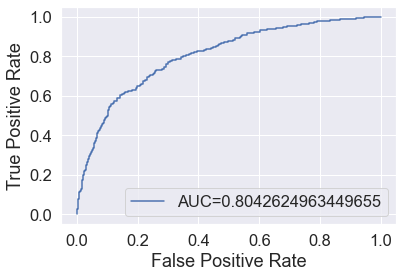

In [101]:
#create ROC curve

y_pred_proba = logisticRegr.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(Y_test,  y_pred_proba)
auc = roc_auc_score(Y_test, y_pred_proba)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

AUC (Area Under Curve) corresponds to the probability that a randomly chosen positive instance is ranked higher than a randomly chosen negative instance. AUC = 0.80 is a decent score, but once again this metric is not the best when data classes are unbalanced as this is the case

<b>We will choose F1 score as our comparison metric when trying new optimisations and models</b>

We will try to optimize the parameters of the logistic regression by making them vary (max_iter and solver)

In [102]:
parameter_grid_logistic_regression = {
    'max_iter': [20, 50, 100, 200, 500, 1000, 2000],                      # Number of iterations
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],   # Algorithm to use for optimization
    'class_weight': [None]}

logistic_Model_grid = GridSearchCV(estimator=LogisticRegression(random_state=1234), param_grid=parameter_grid_logistic_regression, verbose=1, 
                    cv=10, n_jobs=-1)
 
logistic_Model_grid.fit(X_train, Y_train)
 
print("Best score for the model after tuning is: ",logistic_Model_grid.best_score_)
print("Best parameters for the model is :",logistic_Model_grid.best_estimator_)  

Fitting 10 folds for each of 35 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:    7.0s finished


Best score for the model after tuning is:  0.7907375562513903
Best parameters for the model is : LogisticRegression(max_iter=20, random_state=1234, solver='newton-cg')


In [103]:
logisticRegr_opt = LogisticRegression(max_iter=20, random_state=1234, solver='newton-cg')
log_opt = logisticRegr_opt.fit(X_train, Y_train)
y_predict_log_opt = logisticRegr_opt.predict(X_test)

print("Classification Report is: \n",classification_report(Y_test, y_predict_log_opt)) 

Classification Report is: 
               precision    recall  f1-score   support

           0       0.81      0.93      0.86      1171
           1       0.68      0.43      0.53       441

    accuracy                           0.79      1612
   macro avg       0.75      0.68      0.69      1612
weighted avg       0.78      0.79      0.77      1612



We try balancing the data with class_weight = 'balanced'

In [104]:
logisticRegr_b = LogisticRegression(class_weight = 'balanced')
log_b = logisticRegr_b.fit(X_train, Y_train)
y_predict_log_b = logisticRegr_b.predict(X_test)

print("Classification Report is: \n",classification_report(Y_test, y_predict_log_b)) 

Classification Report is: 
               precision    recall  f1-score   support

           0       0.88      0.72      0.79      1171
           1       0.50      0.74      0.60       441

    accuracy                           0.73      1612
   macro avg       0.69      0.73      0.69      1612
weighted avg       0.78      0.73      0.74      1612



<b>Neither the optimization nor the data balancing improve the overall F1-score<b>

### Principal Component Analysis (PCA) 

Let us first examine the covariance matrix of X_train. PCA can take advantage of multicollinearity by combining the highly correlated variables into a set of uncorrelated variables

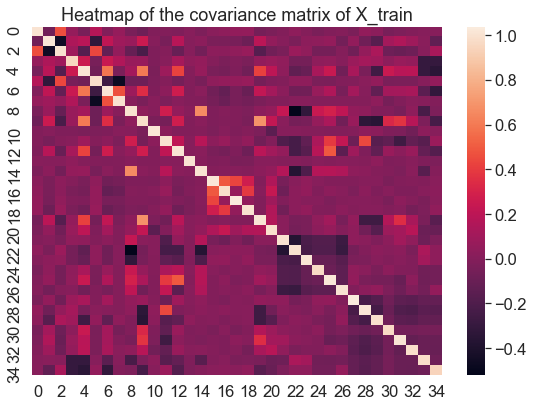

In [105]:
cov_mat = np.cov(X_train.T) 

plt.figure(figsize = (8,6))
sns.set(font_scale = 1.5)
hm = sns.heatmap(cov_mat)
plt.title('Heatmap of the covariance matrix of X_train')
plt.tight_layout()
plt.show()

In [115]:
pca = PCA(n_components = 0.95) #we want the chosen components to explain 95% of the variance of TARGET_FLAG
pca.fit(X_train)
X_train_pca = pd.DataFrame(pca.transform(X_train))
X_test_pca = pd.DataFrame(pca.transform(X_test))
X_train_pca.shape

(4836, 27)

In [116]:
pca.explained_variance_ratio_

array([0.11421815, 0.07857089, 0.0620448 , 0.05321476, 0.05066084,
       0.04751808, 0.03852662, 0.03808368, 0.03589915, 0.03474201,
       0.03430859, 0.03287971, 0.03175112, 0.03097682, 0.02992137,
       0.02930193, 0.02799923, 0.0276974 , 0.02561587, 0.02195331,
       0.02055533, 0.01867168, 0.01737059, 0.01630559, 0.01410849,
       0.01177973, 0.01078898])

In [117]:
logisticRegr_pca = LogisticRegression()
log_pca = logisticRegr_pca.fit(X_train_pca, Y_train)
y_predict_pca = logisticRegr_pca.predict(X_test_pca)
print("Classification Report is: \n",classification_report(Y_test, y_predict_pca)) 

Classification Report is: 
               precision    recall  f1-score   support

           0       0.81      0.93      0.86      1171
           1       0.68      0.42      0.52       441

    accuracy                           0.79      1612
   macro avg       0.74      0.67      0.69      1612
weighted avg       0.77      0.79      0.77      1612



<b>PCA doesn't improve the overall F1-score<b>

### Random Forest Classifier

In [118]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,Y_train)
y_pred=clf.predict(X_test)

print("Classification Report is: \n",classification_report(Y_test, y_pred)) 

Classification Report is: 
               precision    recall  f1-score   support

           0       0.79      0.94      0.86      1171
           1       0.69      0.34      0.46       441

    accuracy                           0.78      1612
   macro avg       0.74      0.64      0.66      1612
weighted avg       0.76      0.78      0.75      1612



We can try to optimize our classifier, which as of yet doesn't have a better F1-Score

In [122]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, Y_train)
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 200}

In [123]:
rfc1 = RandomForestClassifier(max_features='log2', n_estimators= 200, max_depth=8, criterion='gini')
rfc1.fit(X_train,Y_train)
y_pred_rfc_opt = rfc1.predict(X_test)

print("Classification Report is: \n",classification_report(Y_test, y_pred_rfc_opt)) 

Classification Report is: 
               precision    recall  f1-score   support

           0       0.78      0.97      0.86      1171
           1       0.79      0.26      0.39       441

    accuracy                           0.78      1612
   macro avg       0.78      0.62      0.63      1612
weighted avg       0.78      0.78      0.73      1612



This optimization on accuracy still doesn't improve F1-score. We can still use this Random Forest Classifier to get insights on feature importance :

In [124]:
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

blue_book        0.082886
income           0.079911
age              0.076583
trav_time        0.072485
home_val         0.068058
old_claim        0.061928
mvr_pts          0.056211
car_age          0.051577
YOJ              0.049111
TIF              0.047121
clm_freq         0.039782
urbanicity       0.039159
education        0.032769
home_kids        0.023252
car_use          0.020850
revoked          0.017370
m_status         0.016410
kids_driv        0.015456
parent_1         0.015429
Minivan          0.015417
z_Blue Collar    0.011774
red_car          0.011452
sex              0.011243
Manager          0.010853
z_SUV            0.010652
Pickup           0.009386
Sports Car       0.009007
Clerical         0.008026
Professional     0.007979
Van              0.006844
Student          0.005837
Home Maker       0.004742
Panel Truck      0.004529
Lawyer           0.004510
Doctor           0.001398
dtype: float64

Unsurprisingly, parameters directly linked to wealth (income, home_val) and to the state of the car (blue_book, trav_time, car_age) are some of the most important features. Education, the type of the car, and marital status are less important

## Conclusion 

<b>We will choose a basic logistic regression as this has the best F1-score despite our attempts to optimize this method and try new models.<b> 

## Predictions

In [148]:
df_standard_test

,kids_driv,age,home_kids,YOJ,income,parent_1,home_val,m_status,sex,education,trav_time,car_use,blue_book,TIF,red_car,old_claim,clm_freq,revoked,mvr_pts,car_age,urbanicity,Van,Minivan,z_SUV,Pickup,Panel Truck,Sports Car,Manager,z_Blue Collar,Clerical,Professional,Doctor,Lawyer,Student,Home Maker
0,-0.335344,0.347795,-0.648887,0.151328,-0.152136,-0.377587,-1.186627,-1.230716,1.106519,0.167412,-0.467546,-0.745829,0.782080,-1.066402,1.608685,-0.475429,-0.723369,-0.386605,0.101463,0.324839,0.480787,3.393854,-0.588348,-0.633359,-0.46138,-0.292306,-0.373544,2.586616,-0.530814,-0.41792,-0.391572,-0.188754,-0.316329,-0.310721,-0.324077
1,1.725999,-0.588760,0.249290,0.151328,-0.196588,2.648399,-1.186627,-1.230716,1.106519,-0.684551,-0.786345,-0.745829,0.420460,0.173180,-0.621626,-0.096401,0.147823,-0.386605,0.101463,-1.251857,0.480787,-0.294650,1.699673,-0.633359,-0.46138,-0.292306,-0.373544,2.586616,-0.530814,-0.41792,-0.391572,-0.188754,-0.316329,-0.310721,-0.324077
2,-0.335344,-0.120483,1.147467,0.388556,-0.354279,2.648399,-1.186627,-1.230716,-0.903735,-0.684551,-0.212508,1.340789,-1.129511,1.164846,-0.621626,-0.475429,-0.723369,-0.386605,-0.800136,0.324839,-2.079925,-0.294650,-0.588348,1.578883,-0.46138,-0.292306,-0.373544,-0.386605,1.883898,-0.41792,-0.391572,-0.188754,-0.316329,-0.310721,-0.324077
3,-0.335344,1.635559,-0.648887,0.388556,0.591868,-0.377587,-1.186627,-1.230716,1.106519,-0.684551,0.743888,-0.745829,0.002931,-1.066402,1.608685,4.684526,1.019016,-0.386605,1.003062,-1.251857,0.480787,-0.294650,1.699673,-0.633359,-0.46138,-0.292306,-0.373544,2.586616,-0.530814,-0.41792,-0.391572,-0.188754,-0.316329,-0.310721,-0.324077
4,-0.335344,1.752628,-0.648887,0.388556,-0.473608,-0.377587,0.234490,0.812535,-0.903735,-0.684551,-1.105144,1.340789,-0.488349,-1.066402,-0.621626,-0.475429,-0.723369,-0.386605,-0.800136,-1.251857,0.480787,-0.294650,-0.588348,-0.633359,-0.46138,-0.292306,2.677063,-0.386605,1.883898,-0.41792,-0.391572,-0.188754,-0.316329,-0.310721,-0.324077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710,-0.335344,0.113656,-0.648887,-2.458182,-1.289927,-0.377587,-1.186627,0.812535,-0.903735,-0.684551,-0.084988,1.340789,-1.652908,0.173180,-0.621626,1.884896,0.147823,2.586616,0.552262,-0.025538,-2.079925,-0.294650,-0.588348,-0.633359,-0.46138,-0.292306,2.677063,-0.386605,-0.530814,-0.41792,-0.391572,-0.188754,-0.316329,3.218325,-0.324077
1711,-0.335344,0.113656,-0.648887,0.388556,-0.353957,-0.377587,-0.136943,0.812535,1.106519,-0.684551,1.700284,-0.745829,0.081441,-0.570569,-0.621626,-0.475429,-0.723369,-0.386605,0.101463,-1.251857,-2.079925,-0.294650,1.699673,-0.633359,-0.46138,-0.292306,-0.373544,-0.386605,-0.530814,-0.41792,2.553807,-0.188754,-0.316329,-0.310721,-0.324077
1712,-0.335344,1.167281,-0.648887,-0.085900,1.745623,-0.377587,1.874492,0.812535,-0.903735,1.019374,0.552609,-0.745829,0.679779,1.164846,-0.621626,-0.475429,-0.723369,-0.386605,-0.800136,2.427101,-2.079925,-0.294650,-0.588348,-0.633359,-0.46138,-0.292306,2.677063,-0.386605,-0.530814,-0.41792,-0.391572,-0.188754,3.161264,-0.310721,-0.324077
1713,-0.335344,0.699003,-0.648887,-0.085900,1.475381,-0.377587,-1.186627,-1.230716,1.106519,1.019374,-0.977624,1.340789,2.089384,0.173180,-0.621626,-0.015879,1.890208,-0.386605,-0.349337,1.200782,0.480787,-0.294650,-0.588348,-0.633359,-0.46138,3.421068,-0.373544,-0.386605,-0.530814,-0.41792,-0.391572,-0.188754,-0.316329,-0.310721,-0.324077


In [127]:
logisticRegr_final = LogisticRegression()
log_final = logisticRegr_final.fit(X_train, Y_train)
y_predict_final = logisticRegr.predict(df_standard_test)

In [156]:
prediction_df_1 = pd.DataFrame(y_predict_final, columns=['prediction'])
df_index_test_processed = pd.DataFrame(index_test_processed, columns=['index'])
prediction_df = pd.concat([df_index_test_processed, prediction_df_1], axis=1)
prediction_df.to_csv("target_flag_predictions_for_test_auto.csv")
prediction_df['prediction'].value_counts()

0    1445
1     270
Name: prediction, dtype: int64

In [157]:
prediction_df

,index,prediction
0,3,0
1,9,0
2,10,0
3,21,0
4,31,0
...,...,...
1710,10279,0
1711,10281,0
1712,10285,0
1713,10294,0


NB : These predictions only apply to rows in the test data that didn't have any "NaN" values (which are specified by the index). To have predictions for all rows, we could have chosen to remove the columns with "NaN" values instead